# Week 5 Mini Project

### Introduction

The purpose of this project is to build a Generative Adversarial Network (GAN) that can generate images that are in the style of the French painter, Monet. The model will also be able to discriminate between real and generated images.

### Imports

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import shutil
import warnings
warnings.filterwarnings("ignore")

from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.17.1


### Data Ingestion

We will start by ingesting our dataset and making two datasets for the Monet paintings and the photos. We can see there are 5 Monet TF Records available and 20 photo TF Records available. We can see that there are 300 Monet jpgs and about 7000 photo jpgs available.

In [48]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [106]:
monet_tfrecs = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_tfrecs = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

print('# of Monet TF Records:', len(monet_tfrecs))
print('# of Photo TF Records:', len(photo_tfrecs))

monet_jpgs = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
photo_jpgs = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))

print('# of Monet JPGs:', len(monet_jpgs))
print('# of Photo JPGs:', len(photo_jpgs))

# of Monet TF Records: 5
# of Photo TF Records: 20
# of Monet JPGs: 300
# of Photo JPGs: 7038


### Exploratary Data Analysis
We will start with visualizing the images in each of the datasets. We can see that the shape of each image is 256x256 pixels with the 3 RGB color channels.

In [136]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[256, 256], 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    print("Image Shape", image.shape)
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_tfrecs, labeled=True).batch(5)
photo_ds = load_dataset(photo_tfrecs, labeled=True).batch(5)

Image Shape (256, 256, 3)
Image Shape (256, 256, 3)


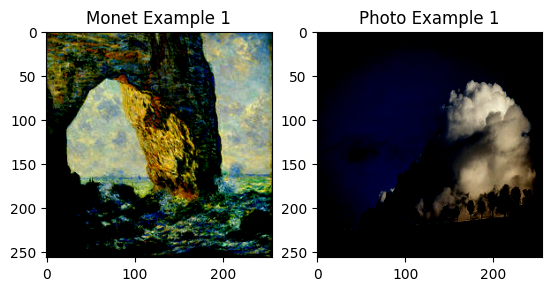

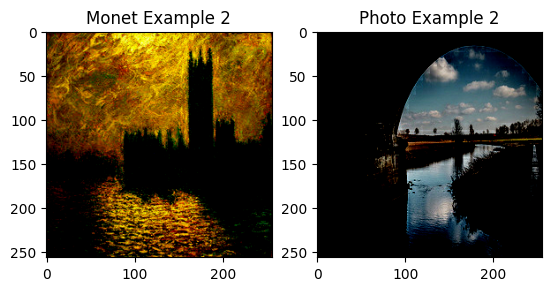

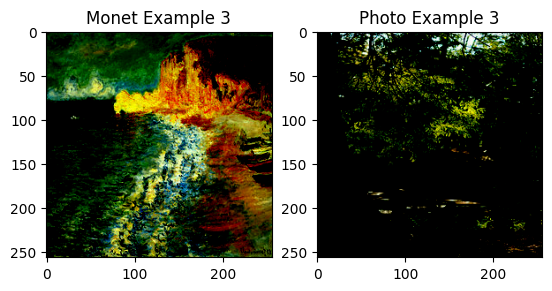

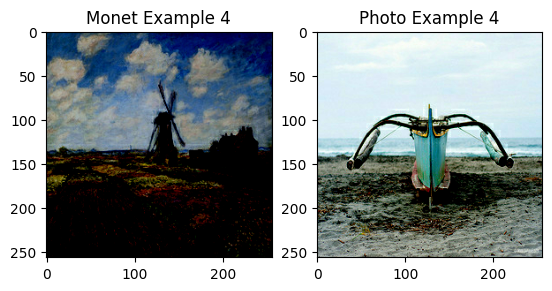

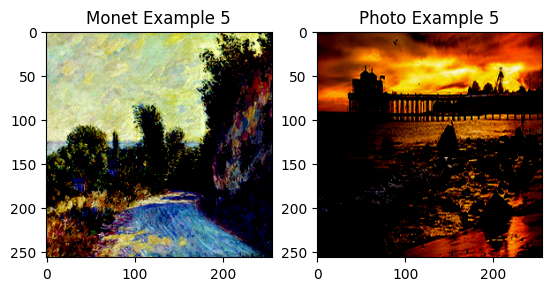

In [103]:
ex_monet = next(iter(monet_ds))
ex_photo = next(iter(photo_ds))

for i in range(0,5):
    plt.subplot(121)
    plt.title(f'Monet Example {i+1}')
    plt.imshow(ex_monet[i])
    plt.subplot(122)
    plt.title(f'Photo Example {i+1}')
    plt.imshow(ex_photo[i])
    plt.show()

Based on this EDA, we have verified that we have Monet paintings and photos for our GAN to process and that the images are unique. For a plan of analysis, we will create a CycleGAN that includes a generator and a discriminator and iterate it in order to create new "Monet" images.

### Model
We will build our model based on Amy Jang's CycleGAN Tutorial. We will create a Generative Adversarial Network consisting of a generator and a discriminator and cycle between generators and discriminators.

The CycleGAN generator transforms a photograph from the dataset into a Monet-like image. It will include a downsample procedure that reduces the dimension of the image and then normalizes it. Then it gets passed to an upsample procedure that then reinstalls the dimensions of the image. It uses a tanh activation function in order to match normalized image pixel values.

The CycleGAN discriminator takes the images and determines if it is real or generated. It uses a convolutional layer to extract the features. If the image is real, the output is an image with higher pixel counts and if it's fake, the pixel counts are smaller.

In [124]:
def downsample(filters, size, apply_instancenorm=True):
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, 
                             size, 
                             strides=2, 
                             padding='same',
                             kernel_initializer=tf.random_normal_initializer(0., 0.02), 
                             use_bias=False))

    if apply_instancenorm:
        result.add(keras.layers.GroupNormalization(groups=-1,
                                                   gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, 
                                      size, 
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                      use_bias=False))

    result.add(keras.layers.GroupNormalization(groups=-1,
                                               gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [125]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [126]:
def Discriminator():
    inp = layers.Input(shape=[256, 256, 3], name='input')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 
                         4, 
                         strides=1,
                         kernel_initializer=tf.random_normal_initializer(0., 0.02),
                         use_bias=False)(zero_pad1) 

    norm1 = keras.layers.GroupNormalization(groups=-1,
                                            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 
                         4, 
                         strides=1,
                         kernel_initializer=tf.random_normal_initializer(0., 0.02))(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

Now, we will define the generator and discriminator objects for the paintings and the photos.

In [127]:
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator() 

### Training the Model


First we will define loss functions for the generator and discriminator as well as the cycle and identity loss. These losses limit the errors for their respective components.

In [128]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Next, we will define our optimizers for each compoenent using the Adam optimizer.

In [129]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [130]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Cycle 1
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Cycle 2
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Call generator
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Input real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Input generated images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluate generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluate discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Update weights
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now, we will define the CycleGan model, compile it using the defined optimizers and loss functions, and then we will tune the epoch hyperparameter to see at which number of epochs does our model perform the best. We will test with 5, 10, and 15 epochs.

#### Model 1 - 5 Epochs

In [131]:
with strategy.scope():
    cycle_gan_model1 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    cycle_gan_model1.compile(m_gen_optimizer = monet_generator_optimizer,
                             p_gen_optimizer = photo_generator_optimizer,
                             m_disc_optimizer = monet_discriminator_optimizer,
                             p_disc_optimizer = photo_discriminator_optimizer,
                             gen_loss_fn = generator_loss,
                             disc_loss_fn = discriminator_loss,
                             cycle_loss_fn = calc_cycle_loss,
                             identity_loss_fn = identity_loss)

In [138]:
cycle_gan_model1.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=5)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - monet_disc_loss: 0.5060 - monet_gen_loss: 4.1135 - photo_disc_loss: 0.4602 - photo_gen_loss: 4.3697
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 621ms/step - monet_disc_loss: 0.5334 - monet_gen_loss: 4.1267 - photo_disc_loss: 0.4497 - photo_gen_loss: 4.4079
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 637ms/step - monet_disc_loss: 0.4807 - monet_gen_loss: 4.1742 - photo_disc_loss: 0.4875 - photo_gen_loss: 4.4095
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 629ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 4.0751 - photo_disc_loss: 0.4580 - photo_gen_loss: 4.3870
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 628ms/step - monet_disc_loss: 0.5303 - monet_gen_loss: 4.0937 - photo_disc_loss: 0.4694 - photo_gen_loss: 4.3361


#### Model 2 - 10 Epochs

In [149]:
with strategy.scope():
    cycle_gan_model2 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    cycle_gan_model2.compile(m_gen_optimizer = monet_generator_optimizer,
                             p_gen_optimizer = photo_generator_optimizer,
                             m_disc_optimizer = monet_discriminator_optimizer,
                             p_disc_optimizer = photo_discriminator_optimizer,
                             gen_loss_fn = generator_loss,
                             disc_loss_fn = discriminator_loss,
                             cycle_loss_fn = calc_cycle_loss,
                             identity_loss_fn = identity_loss)

In [150]:
cycle_gan_model2.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=10)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 665ms/step - monet_disc_loss: 0.5214 - monet_gen_loss: 4.1686 - photo_disc_loss: 0.5595 - photo_gen_loss: 4.2923
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 619ms/step - monet_disc_loss: 0.4884 - monet_gen_loss: 4.0587 - photo_disc_loss: 0.5782 - photo_gen_loss: 4.0202
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 637ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 3.9233 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.9355
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 627ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.7660 - photo_disc_loss: 0.5495 - photo_gen_loss: 3.9195
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 3.6881 - photo_disc_loss: 0.5253 - photo_gen_loss: 3.9062
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.6879 - photo_disc_loss: 0.5401 - photo_gen_loss: 3.8807
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 628ms/step - monet_disc_los

#### Model 3 - 15 epochs

In [154]:
with strategy.scope():
    cycle_gan_model3 = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    cycle_gan_model3.compile(m_gen_optimizer = monet_generator_optimizer,
                             p_gen_optimizer = photo_generator_optimizer,
                             m_disc_optimizer = monet_discriminator_optimizer,
                             p_disc_optimizer = photo_discriminator_optimizer,
                             gen_loss_fn = generator_loss,
                             disc_loss_fn = discriminator_loss,
                             cycle_loss_fn = calc_cycle_loss,
                             identity_loss_fn = identity_loss)

In [155]:
cycle_gan_model3.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=15)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 660ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.4973 - photo_disc_loss: 0.5698 - photo_gen_loss: 3.6062
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 619ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 3.4610 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.6280
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 634ms/step - monet_disc_loss: 0.6371 - monet_gen_loss: 3.3925 - photo_disc_loss: 0.5435 - photo_gen_loss: 3.6306
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 629ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 3.3596 - photo_disc_loss: 0.5646 - photo_gen_loss: 3.6026
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 629ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 3.3474 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.5328
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 629ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.2849 - photo_disc_loss: 0.5673 - photo_gen_loss: 3.4512
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 626ms/step - monet_disc_los

### Results and Analysis

#### Hyperparemeter Tuning Summary
We fit our CycleGAN model with 3 different lengths of epochs to see how that would affect the performance of the model. From the loss values, we can see that Model 3 with a epoch size of 15 was the best model due to it having a consistently decreasing generator loss for both the photos and the Monet images and also having the lowest loss overall across the 3 models. It's lowest loss was around 3.2 while the 10 epoch model had a loss around 3.6 and the 5 epoch model has a loss around 4.25.

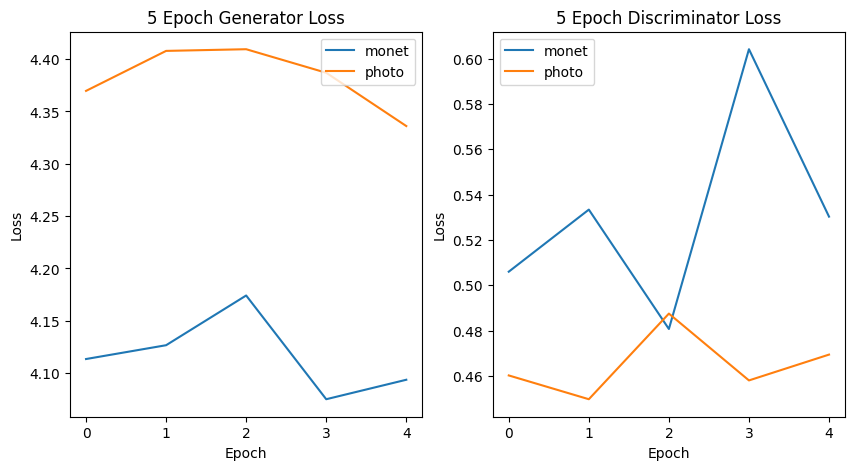

In [178]:
monet_disc_loss = [0.5060, 0.5334, 0.4807, 0.6042, 0.5303]
photo_disc_loss = [0.4602, 0.4497, 0.4875, 0.4580, 0.4694]
monet_gen_loss = [4.1135, 4.1267, 4.1742, 4.0751, 4.0937]
photo_gen_loss = [4.3697, 4.4079, 4.4095, 4.3870, 4.3361]

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(monet_gen_loss)
axs[0].plot(photo_gen_loss)
axs[0].set_title('5 Epoch Generator Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['monet', 'photo'], loc='upper right')
axs[1].plot(monet_disc_loss)
axs[1].plot(photo_disc_loss)
axs[1].set_title('5 Epoch Discriminator Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['monet', 'photo'], loc='upper left')

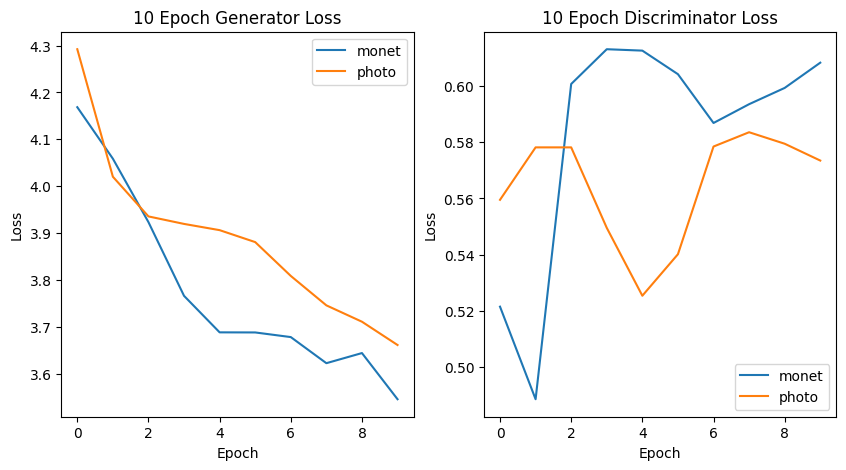

In [177]:
monet_disc_loss_2 = [0.5214, 0.4884, 0.6008, 0.6132, 0.6127, 0.6043, 0.5869, 0.5936, 0.5994, 0.6084]
photo_disc_loss_2 = [0.5595, 0.5782, 0.5782, 0.5495, 0.5253, 0.5401, 0.5785, 0.5836, 0.5795, 0.5735]
monet_gen_loss_2 = [4.1686, 4.0587, 3.9233, 3.7660, 3.6881, 3.6879, 3.6780, 3.6223, 3.6439, 3.5454]
photo_gen_loss_2 = [4.2923, 4.0202, 3.9355, 3.9195, 3.9062, 3.8807, 3.8085, 3.7457, 3.7108, 3.6611]

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(monet_gen_loss_2)
axs[0].plot(photo_gen_loss_2)
axs[0].set_title('10 Epoch Generator Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['monet', 'photo'], loc='upper right')
axs[1].plot(monet_disc_loss_2)
axs[1].plot(photo_disc_loss_2)
axs[1].set_title('10 Epoch Discriminator Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['monet', 'photo'], loc='lower right')

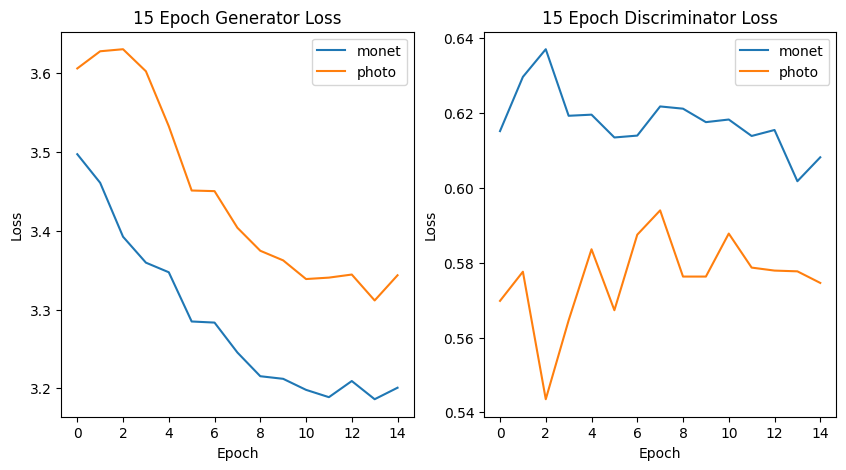

In [176]:
monet_disc_loss_3 = [0.6152, 0.6297, 0.6371, 0.6193, 0.6196, 0.6135, 0.6140, 0.6218, 0.6212, 
                     0.6176, 0.6183, 0.6139, 0.6155, 0.6018, 0.6082]
photo_disc_loss_3 = [0.5698, 0.5776, 0.5435, 0.5646, 0.5836, 0.5673, 0.5875, 0.5940, 0.5763, 
                     0.5763, 0.5878, 0.5787, 0.5779, 0.5777, 0.5746]
monet_gen_loss_3 = [3.4973, 3.4610, 3.3925, 3.3596, 3.3474, 3.2849, 3.2835, 3.2455, 3.2154, 
                     3.2121, 3.1981, 3.1888, 3.2093, 3.1862, 3.2008]
photo_gen_loss_3 = [3.6062, 3.6280, 3.6306, 3.6026, 3.5328, 3.4512, 3.4504, 3.4039, 3.3747, 
                     3.3625, 3.3388, 3.3406, 3.3445, 3.3116, 3.3436]

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(monet_gen_loss_3)
axs[0].plot(photo_gen_loss_3)
axs[0].set_title('15 Epoch Generator Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['monet', 'photo'], loc='upper right')
axs[1].plot(monet_disc_loss_3)
axs[1].plot(photo_disc_loss_3)
axs[1].set_title('15 Epoch Discriminator Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['monet', 'photo'], loc='upper right')

Now that the model is trained, we will visualize the generated Monet images. As seen below, the images look fairly close to their reference images, which means that our model worked well. The generated images are a little grainer compared to the photos and are clearly more fuzzy around the edges of the picture, but we can tell what the images are supposed to represent.

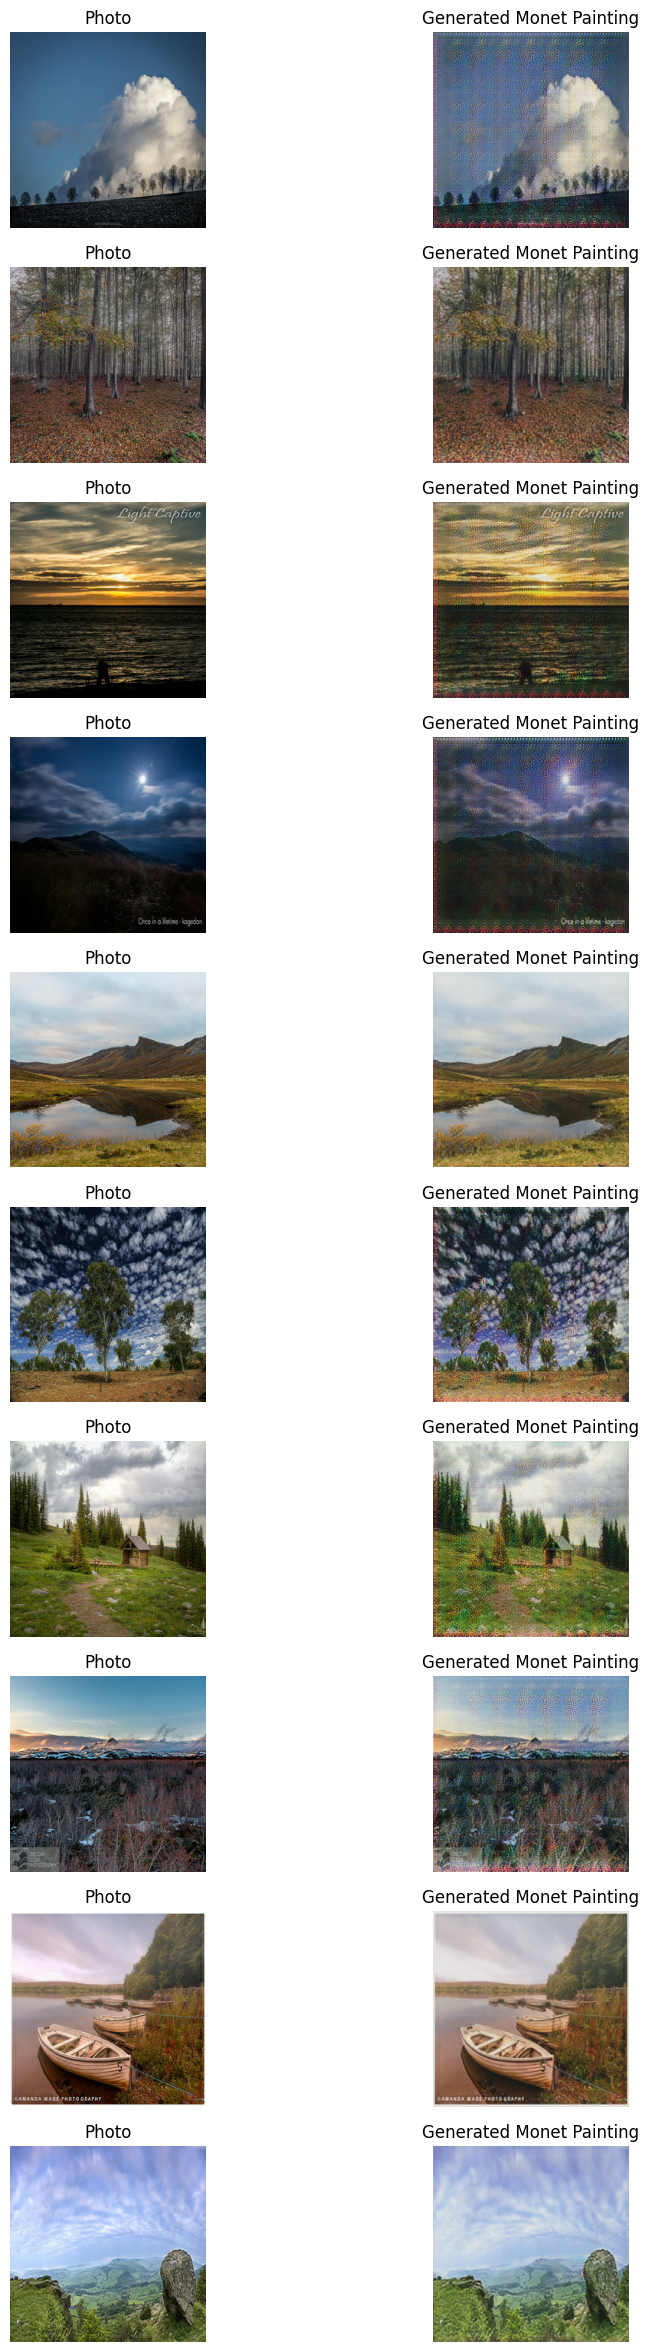

In [180]:
_, ax = plt.subplots(10, 2, figsize=(10, 30))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Photo")
    ax[i, 1].set_title("Generated Monet Painting")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Submission File

In [181]:
! mkdir ../images
count = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(count) + ".jpg")
    count += 1
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### Conclusion
In conclusion, we created CycleGAN model to generate fake Monet images from real photos and discriminate between real and fake images. We tuned on the number of epochs to see how that would affect the performance of the model and determined that the model that used 15 epochs was the highest performing after comparing the generator and discriminator loss values for each model. Using that model, we visualy inspecting the gerenated images and found that they looked very similar to the photographs they were trained against.

#### Takeaways:
* The model with an epoch size 15 was the best model for this dataset.

#### Improvements:
* Experiment with changing the architecture/layers for the generator and discriminator functions.
* Experiment with using other functions for loss or optimization.

### References
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial